In [163]:
import skimage
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage import color, feature, segmentation, util 
import matplotlib.pyplot as plt 

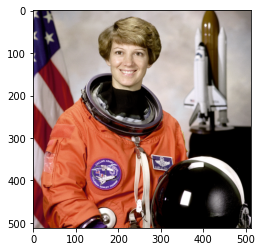

In [164]:
image = skimage.data.astronaut()
plt.imshow(image)

In [168]:
"""
 Dùng thuật toán của Felzenswalb và Huttenlocher bằng thư viện có sẵn
 Hiểu đơn giản là phân loại các pixel
"""
def oversegmentation(img):
  img_seg = felzenszwalb(img,scale = 1  , sigma= 0.8 , min_size = 50)
  img = np.append(
      img,np.zeros(img.shape[:2])[:,:,np.newaxis],axis = 2
  )
  img[:,:,3] = img_seg
  return img,img_seg


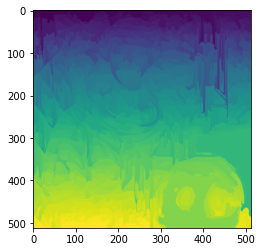

In [169]:
"""
test segmentation
"""
img_ger,img_seg =  oversegmentation(image)
plt.imshow(img_seg)

In [170]:
img_seg

array([[   0,    0,    0, ...,   39,   39,   39],
       [   0,    0,    0, ...,   39,   39,   39],
       [   0,    0,    0, ...,   39,   39,   39],
       ...,
       [1124, 1124, 1124, ..., 1100, 1100, 1100],
       [1124, 1124, 1124, ..., 1100, 1100, 1100],
       [1124, 1124, 1124, ..., 1100, 1100, 1100]])

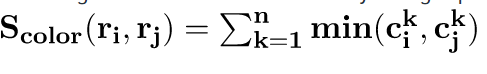

In [171]:
"""
Độ tương đồng về màu 
"""
def similar_color(r1,r2):
  return sum([min(a,b) for a,b in zip(r1['hist_color'],r2['hist_color'])])
  

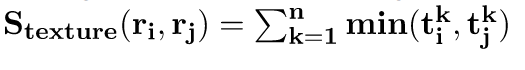

In [172]:
"""
Độ tương đồng về kết cấu
"""
def similar_texture(r1,r2):
  return sum([min(a,b) for a,b in zip(r1['hist_texture'],r2['hist_texture'])])


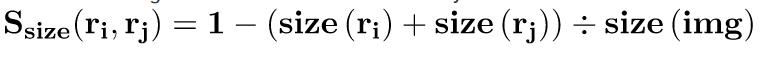

In [173]:
"""
Độ tương đồng về kích thước
"""
def similar_size(r1,r2,img_size):
  return 1.0 - (r1['size'] + r2['size'])/img_size
  

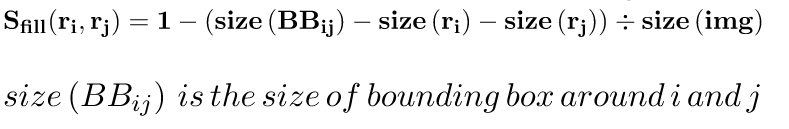

In [174]:
"""
Độ chồng lên nhau
"""
def similar_fill(r1,r2,img_size):
  bbsize = (
        (max(r1['max_x'], r2['max_x']) - min(r1['min_x'], r2['min_x']))
        * (max(r1['max_y'], r2['max_y']) - min(r1['min_y'], r2['min_y']))
    )
  return 1.0 - (bbsize - r1['size'] - r2['size']) / img_size


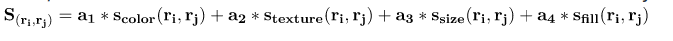

In [176]:
"""
Tổng độ tương đồng 
"""
def similar_sum(r1,r2,img_size):
  return (similar_color(r1,r2) + similar_texture(r1,r2) + similar_size(r1,r2,img_size) + similar_fill(r1,r2,img_size))


In [177]:
""" 
Tính r1['hist_color'] hay r2['hist_color'] như thế nào ??
"""
def calc_hist_color(img,color_bins):
  hist = np.array([])
  for color_channel in (0,1,2):
    c = img[:,color_channel]
    hist = np.concatenate(
        [hist] + [np.histogram(c,bins = color_bins, range = (0.0,255.0))[0]]
    )
    hist = hist / len(img)
    return hist



In [178]:
""" 
Tính r1['hist_texture'] hay r2['hist_texture'] như thế nào ???
"""

def calc_texture_gradient(img):
  ret = np.zeros((img.shape[0], img.shape[1], img.shape[2]))

  for color_channel in (0, 1, 2):
    ret[:, :, color_channel] = feature.local_binary_pattern(
        img[:, :, color_channel], 8, 1.0)

  return ret
def _calc_texture_hist(img, texture_bins):
    hist = np.array([])
    for color_channel in (0, 1, 2):
        fd = img[:, color_channel]
        hist = np.concatenate(
            [hist] + [np.histogram(fd, bins=texture_bins, range=(0.0, 255.0))[0]])

    hist = hist / len(img)

    return hist

In [179]:
def extract_regions(img, color_bins, texture_bins):
    R: dict = {}

    # get hsv image
    hsv = color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):
        for x, (r, g, b, l) in enumerate(i):
            # initialize a new region
            if l not in R:
                R[l] = {
                    'min_x': 0xffff, 'min_y': 0xffff,
                    'max_x': 0, 'max_y': 0, 'labels': [l]}

            # bounding box
            if R[l]['min_x'] > x:
                R[l]['min_x'] = x
            if R[l]['min_y'] > y:
                R[l]['min_y'] = y
            if R[l]['max_x'] < x:
                R[l]['max_x'] = x
            if R[l]['max_y'] < y:
                R[l]['max_y'] = y

    tex_grad = calc_texture_gradient(img)
    for k, v in R.items():
        # color histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]['size'] = len(masked_pixels / 4)
        R[k]['hist_color'] = calc_hist_color(masked_pixels, color_bins)

        # texture histogram
        R[k]['hist_texture'] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k], texture_bins)

    return R

In [180]:
"""
test xuất ra các vùng thô
"""
R = extract_regions(img_ger, 25, 10) 

In [181]:
len(R),R[0]

(1153,
 {'min_x': 0,
  'min_y': 0,
  'max_x': 11,
  'max_y': 21,
  'labels': [0.0],
  'size': 181,
  'hist_color': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  'hist_texture': array([0.17127072, 0.15469613, 0.23756906, 0.02209945, 0.1878453 ,
         0.00552486, 0.        , 0.03867403, 0.07734807, 0.10497238,
         0.16022099, 0.16022099, 0.2320442 , 0.02762431, 0.20441989,
         0.        , 0.        , 0.04972376, 0.07734807, 0.08839779,
         0.16022099, 0.16022099, 0.2320442 , 0.01104972, 0.20994475,
         0.01657459, 0.        , 0.02762431, 0.07734807, 0.10497238])})

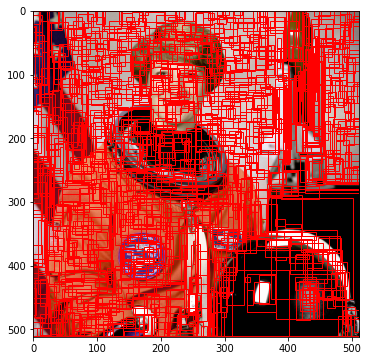

In [182]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
for i in range (len(R)):
  x1 = R[i]['min_x']
  x2 = R[i]['max_x']
  y1 = R[i]['min_y']
  y2 = R[i]['max_y']
  bbox = mpatches.Rectangle(
        (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='red', linewidth=1)
  ax.add_patch(bbox)



In [183]:
def extract_neighbors(regions):

    def intersect(a: dict, b: dict) -> bool:
        if (a['min_x'] < b['min_x'] < a['max_x']
                and a['min_y'] < b['min_y'] < a['max_y']) or (
            a['min_x'] < b['max_x'] < a['max_x']
                and a['min_y'] < b['max_y'] < a['max_y']) or (
            a['min_x'] < b['min_x'] < a['max_x']
                and a['min_y'] < b['max_y'] < a['max_y']) or (
            a['min_x'] < b['max_x'] < a['max_x']
                and a['min_y'] < b['min_y'] < a['max_y']):
            return True
        return False

    R = list(regions.items())
    neighbors = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbors.append((a, b))

    return neighbors

In [184]:
neighbors = extract_neighbors(R)

In [185]:
def merge_regions(r1, r2):
    new_size = r1['size'] + r2['size']
    rt = {
        'min_x': min(r1['min_x'], r2['min_x']),
        'min_y': min(r1['min_y'], r2['min_y']),
        'max_x': max(r1['max_x'], r2['max_x']),
        'max_y': max(r1['max_y'], r2['max_y']),
        'size': new_size,
        'hist_color': (
            r1['hist_color'] * r1['size'] + r2['hist_color'] * r2['size']) / new_size,
        'hist_texture': (
            r1['hist_texture'] * r1['size'] + r2['hist_texture'] * r2['size']) / new_size,
        'labels': r1['labels'] + r2['labels']
    }
    return rt

In [186]:
mer_neighbors = []
for (ai, ar), (bi, br) in neighbors:
  mer_neighbors.append(merge_regions(ar,br))


In [187]:
len(mer_neighbors),mer_neighbors[0]

(4494,
 {'min_x': 0,
  'min_y': 0,
  'max_x': 24,
  'max_y': 115,
  'size': 703,
  'hist_color': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  'hist_texture': array([0.11806543, 0.08250356, 0.20910384, 0.0227596 , 0.35704125,
         0.00142248, 0.        , 0.01280228, 0.02133713, 0.17496444,
         0.13229018, 0.09388336, 0.19203414, 0.02987198, 0.3200569 ,
         0.00142248, 0.        , 0.01564723, 0.01991465, 0.19487909,
         0.12802276, 0.08961593, 0.20483642, 0.0170697 , 0.3541963 ,
         0.00426743, 0.00142248, 0.0113798 , 0.01991465, 0.16927454]),
  'labels': [0.0, 72.0]})

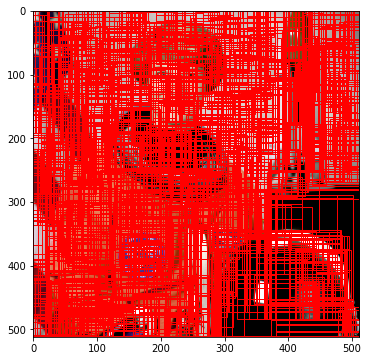

In [188]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
for i in range (len(mer_neighbors)):
  x1 = mer_neighbors[i]['min_x']
  x2 = mer_neighbors[i]['max_x']
  y1 = mer_neighbors[i]['min_y']
  y2 = mer_neighbors[i]['max_y']
  bbox = mpatches.Rectangle(
        (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='red', linewidth=1)
  ax.add_patch(bbox)

In [189]:
def selective_search(im_orig: np.ndarray, color_bins: int=25, texture_bins: int=10) -> tuple:

    if im_orig.shape[2] != 3:
        raise ValueError('Expected 3-channel image')

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img_ger,img_seg = oversegmentation(im_orig)



    imsize = img_ger.shape[0] * img_ger.shape[1]
    R = extract_regions(img_ger, color_bins, texture_bins)

    # extract neighboring information
    neighbors = extract_neighbors(R)

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbors:
        S[(ai, bi)] = similar_sum(ar, br, imsize)

    # hierarchal search
    while S != {}:
        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in S.items():
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = similar_sum(R[t], R[n], imsize)

    regions = []
    for k, r in R.items():
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'], r['max_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return regions

In [190]:
regions = selective_search(image)

In [194]:
candidates =[]
for r in regions:
        # Exclude same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # Exclude small regions
        if r['size'] < 1000:
            continue
        # Exclude distorted rects
        min_x, min_y, max_x, max_y = r['rect']
        width, height = max_x - min_x + 1, max_y - min_y + 1
        if width / height > 1.5 or height / width > 1.5:
            continue
        candidates.append(r['rect'])

In [195]:
len(candidates)

140

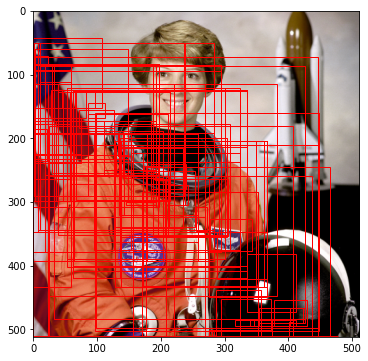

In [198]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
for x1,x2,y1,y2 in (candidates):
  bbox = mpatches.Rectangle(
        (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='red', linewidth=1)
  ax.add_patch(bbox)